# Plan of Action

In [1]:
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path("..").resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
import itertools
from sklearn.metrics import confusion_matrix
from common_utils import *
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

np.random.seed(42)
tf.random.set_seed(42)

2025-04-02 12:20:11.741750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743596411.757747    1588 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743596411.762618    1588 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743596411.775357    1588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743596411.775384    1588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743596411.775386    1588 computation_placer.cc:177] computation placer alr

## Import Dataset

In [2]:

image_paths_csv = pd.read_csv("./processed_data/image_paths.csv")
paths_train_df, paths_val_df, paths_test_df = split_data(image_paths_csv)


## Organize Dataset

In [3]:

paths_train_df_list = list(paths_train_df['path'])
paths_train_labels_list = list(paths_train_df['age_bin'])


paths_test_df_list = list(paths_test_df['path'])
paths_test_labels_list = list(paths_test_df['age_bin'])


In [4]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(paths_train_df_list)
train_aug_labels_tensor = tf.constant(paths_train_labels_list)

test_filenames_tensor = tf.constant(paths_test_df_list)
test_labels_tensor = tf.constant(paths_test_labels_list)


I0000 00:00:1743596413.641144    1588 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:e4:00.0, compute capability: 8.9


# Image Greyscale Function

In [5]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 13

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [6]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

# CNN Architecture

In [31]:
# Defining the architecture of the sequential neural network.

model=build_sequential_cnn_model(
    channels=1,
    dropout_rate=0,
    task="classification",
    num_classes=13,
    num_conv_layers=4,
    conv_filters=[32, 64, 128, 256],
    kernel_size=3,
    activation="relu",
    num_dense_layers=1,
    dense_units=[132],
    output_activation="softmax"
)

final_cnn = Sequential([
    Input(shape=(200, 200, 1)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    Conv2D(filters=64, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    Conv2D(filters=128, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    Conv2D(filters=256, kernel_size=3, activation='relu'),
    AveragePooling2D(pool_size=(2,2)),

    GlobalAveragePooling2D(),
    Dense(132, activation='relu'),
    Dense(13, activation='softmax')
])
final_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 99, 99, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 48, 48, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_14            │ (None, 23, 23, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_15            │ (None, 10, 10, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 132)            │        33,924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │         1,729 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,493 (1.62 MB)

 Trainable params: 423,493 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  # Fixed loss function.
        metrics=['accuracy']
    )
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Fitting

In [33]:
# Fitting the above created CNN model.

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=120,
                                  verbose=2,
                                  # callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )





Epoch 1/120
14/14 - 9s - 640ms/step - accuracy: 0.1011 - loss: 4.3975 - val_accuracy: 0.1651 - val_loss: 2.4677
Epoch 2/120
14/14 - 1s - 106ms/step - accuracy: 0.1629 - loss: 2.4521 - val_accuracy: 0.2330 - val_loss: 2.4380
Epoch 3/120
14/14 - 1s - 105ms/step - accuracy: 0.1709 - loss: 2.4411 - val_accuracy: 0.1442 - val_loss: 2.4634
Epoch 4/120
14/14 - 2s - 109ms/step - accuracy: 0.1658 - loss: 2.4362 - val_accuracy: 0.2142 - val_loss: 2.4117
Epoch 5/120
14/14 - 2s - 109ms/step - accuracy: 0.2108 - loss: 2.3913 - val_accuracy: 0.2268 - val_loss: 2.4146
Epoch 6/120
14/14 - 2s - 109ms/step - accuracy: 0.1997 - loss: 2.4493 - val_accuracy: 0.2445 - val_loss: 2.3871
Epoch 7/120
14/14 - 2s - 114ms/step - accuracy: 0.2229 - loss: 2.3676 - val_accuracy: 0.2466 - val_loss: 2.3539
Epoch 8/120
14/14 - 1s - 106ms/step - accuracy: 0.2249 - loss: 2.3433 - val_accuracy: 0.2539 - val_loss: 2.3381
Epoch 9/120
14/14 - 2s - 122ms/step - accuracy: 0.2406 - loss: 2.3224 - val_accuracy: 0.2560 - val_loss:

In [34]:
history=model.fit(
        train_aug_dataset,
        batch_size=512,
        validation_data=test_dataset,
        epochs=120,
        verbose=2,
        shuffle=False
    )

Epoch 1/120
14/14 - 9s - 647ms/step - accuracy: 0.1052 - loss: 5.3519 - val_accuracy: 0.1442 - val_loss: 2.4810
Epoch 2/120
14/14 - 2s - 110ms/step - accuracy: 0.1644 - loss: 2.4620 - val_accuracy: 0.1442 - val_loss: 2.4533
Epoch 3/120
14/14 - 1s - 106ms/step - accuracy: 0.1757 - loss: 2.4358 - val_accuracy: 0.1442 - val_loss: 2.4928
Epoch 4/120
14/14 - 2s - 114ms/step - accuracy: 0.1892 - loss: 2.4403 - val_accuracy: 0.2362 - val_loss: 2.4077
Epoch 5/120
14/14 - 2s - 121ms/step - accuracy: 0.2114 - loss: 2.4041 - val_accuracy: 0.2100 - val_loss: 2.3945
Epoch 6/120
14/14 - 2s - 121ms/step - accuracy: 0.2097 - loss: 2.3810 - val_accuracy: 0.2320 - val_loss: 2.3912
Epoch 7/120
14/14 - 2s - 122ms/step - accuracy: 0.2378 - loss: 2.3300 - val_accuracy: 0.2602 - val_loss: 2.3063
Epoch 8/120
14/14 - 2s - 120ms/step - accuracy: 0.2538 - loss: 2.2773 - val_accuracy: 0.2612 - val_loss: 2.2673
Epoch 9/120
14/14 - 2s - 117ms/step - accuracy: 0.2484 - loss: 2.3133 - val_accuracy: 0.2623 - val_loss:

In [35]:
model

<Sequential name=sequential_2, built=True>

# Checking Model Performance

In [36]:
histories=[]
histories.append(final_cnn_history)
histories.append(history)

In [37]:
df_list = []
for i, hist in enumerate(histories):
    epochs = range(1, len(hist.history['loss']) + 1)
    if hist==history:
        print("first model")
    else:
        print("second model")

    df = pd.DataFrame({
        'model_object': model if hist==history else final_cnn,
        'epoch': list(epochs),
        'loss': hist.history['loss'],
        'val_loss': hist.history['val_loss'],
        'accuracy': hist.history['accuracy'],
        'val_accuracy': hist.history['val_accuracy']
    })
    df['model'] = f"Model_{i+1}"
    df_list.append(df)

# Combine the DataFrames into one
df_combined = pd.concat(df_list, ignore_index=True)
df_combined


second model
first model


,model_object,epoch,loss,val_loss,accuracy,val_accuracy,model
0,"<Sequential name=sequential_3, built=True>",1,4.397542,2.467699,0.101132,0.165099,Model_1
1,"<Sequential name=sequential_3, built=True>",2,2.452145,2.437964,0.162943,0.233020,Model_1
2,"<Sequential name=sequential_3, built=True>",3,2.441090,2.463382,0.170923,0.144201,Model_1
3,"<Sequential name=sequential_3, built=True>",4,2.436183,2.411650,0.165844,0.214211,Model_1
4,"<Sequential name=sequential_3, built=True>",5,2.391321,2.414571,0.210824,0.226750,Model_1
...,...,...,...,...,...,...,...
235,"<Sequential name=sequential_2, built=True>",116,0.915268,1.817442,0.652496,0.415883,Model_2
236,"<Sequential name=sequential_2, built=True>",117,0.901468,1.802602,0.659750,0.398119,Model_2
237,"<Sequential name=sequential_2, built=True>",118,0.884587,1.798462,0.670488,0.414838,Model_2
238,"<Sequential name=sequential_2, built=True>",119,0.857930,1.823235,0.678758,0.412748,Model_2


In [38]:
models = df_combined['model'].unique()


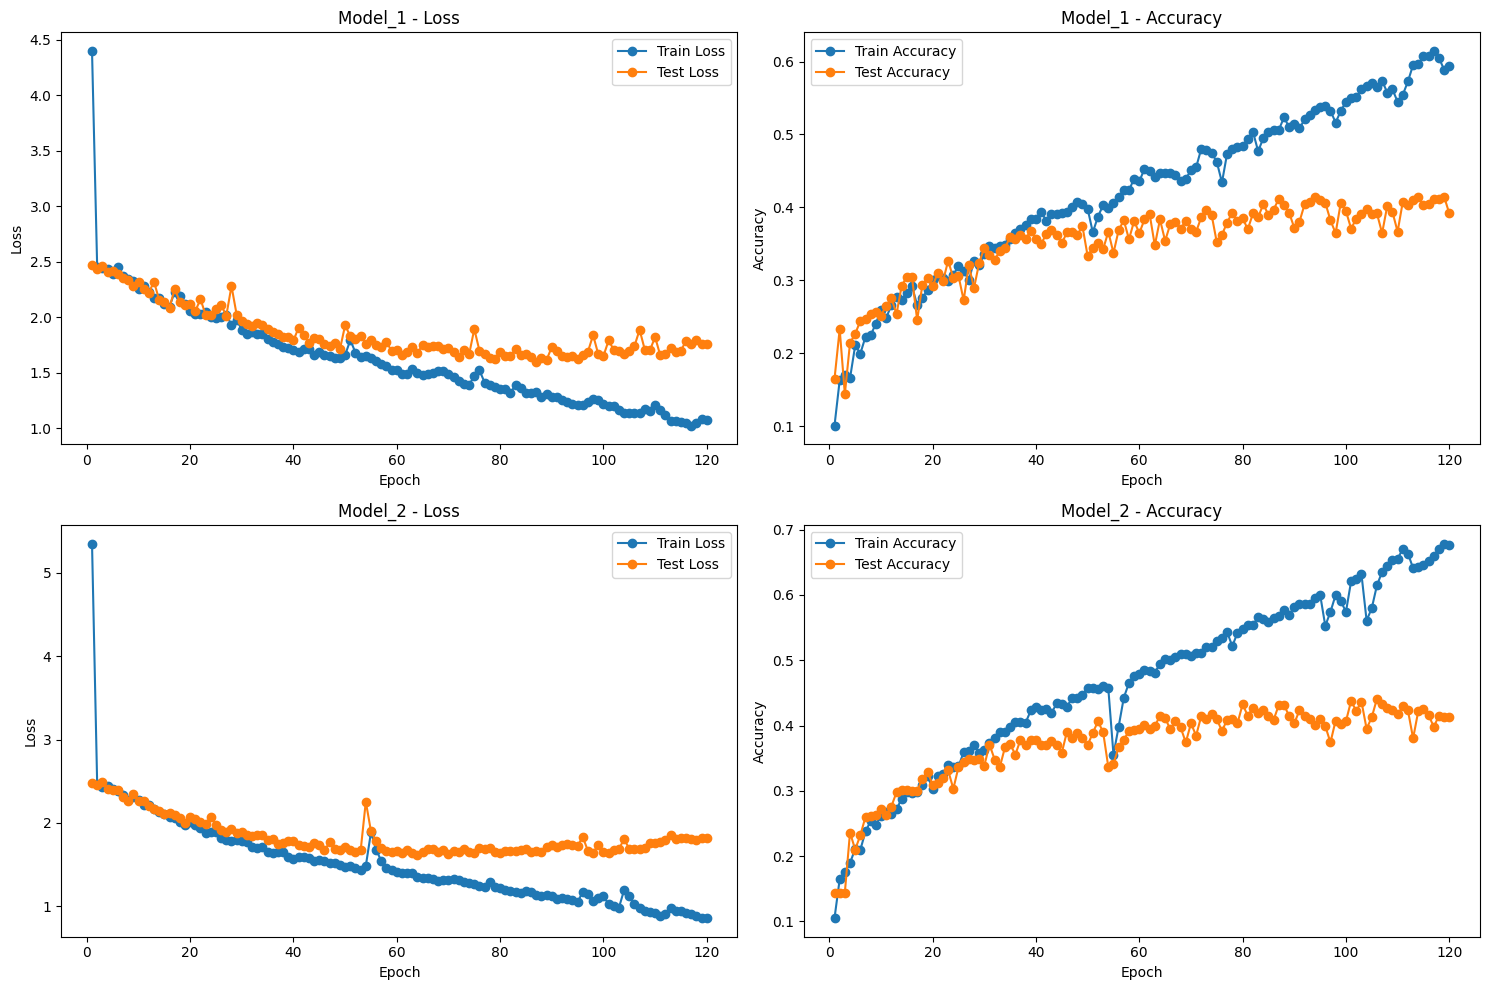

In [39]:

# Create subplots: one row per model and two columns (loss and accuracy)
fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(15, 5 * len(models)))

# Ensure axes is 2D even if there is only one model
if len(models) == 1:
    axes = np.array([axes])

for i, model_entry in enumerate(models):
    # Filter the dataframe for this model
    df_model = df_combined[df_combined['model'] == model_entry]
    # Pick the top 10 rows with the highest training accuracy
    # df_top10 = df_model.nlargest(10, 'accuracy').sort_values('epoch')
    
    # Left subplot: Loss curves
    ax_loss = axes[i, 0]
    ax_loss.plot(df_model['epoch'], df_model['loss'], label='Train Loss', marker='o')
    ax_loss.plot(df_model['epoch'], df_model['val_loss'], label='Test Loss', marker='o')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title(f'{model_entry} - Loss')
    ax_loss.legend()
    
    # Right subplot: Accuracy curves
    ax_acc = axes[i, 1]
    ax_acc.plot(df_model['epoch'], df_model['accuracy'], label='Train Accuracy', marker='o')
    ax_acc.plot(df_model['epoch'], df_model['val_accuracy'], label='Test Accuracy', marker='o')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_title(f'{model_entry} - Accuracy')
    ax_acc.legend()

plt.tight_layout()
plt.show()


In [43]:
df_combined


,model_object,epoch,loss,val_loss,accuracy,val_accuracy,model
0,"<Sequential name=sequential_3, built=True>",1,4.397542,2.467699,0.101132,0.165099,Model_1
1,"<Sequential name=sequential_3, built=True>",2,2.452145,2.437964,0.162943,0.233020,Model_1
2,"<Sequential name=sequential_3, built=True>",3,2.441090,2.463382,0.170923,0.144201,Model_1
3,"<Sequential name=sequential_3, built=True>",4,2.436183,2.411650,0.165844,0.214211,Model_1
4,"<Sequential name=sequential_3, built=True>",5,2.391321,2.414571,0.210824,0.226750,Model_1
...,...,...,...,...,...,...,...
235,"<Sequential name=sequential_2, built=True>",116,0.915268,1.817442,0.652496,0.415883,Model_2
236,"<Sequential name=sequential_2, built=True>",117,0.901468,1.802602,0.659750,0.398119,Model_2
237,"<Sequential name=sequential_2, built=True>",118,0.884587,1.798462,0.670488,0.414838,Model_2
238,"<Sequential name=sequential_2, built=True>",119,0.857930,1.823235,0.678758,0.412748,Model_2


In [64]:
df_combined

,model_object,epoch,loss,val_loss,accuracy,val_accuracy,model
0,"<Sequential name=sequential_3, built=True>",1,4.397542,2.467699,0.101132,0.165099,Model_1
1,"<Sequential name=sequential_3, built=True>",2,2.452145,2.437964,0.162943,0.233020,Model_1
2,"<Sequential name=sequential_3, built=True>",3,2.441090,2.463382,0.170923,0.144201,Model_1
3,"<Sequential name=sequential_3, built=True>",4,2.436183,2.411650,0.165844,0.214211,Model_1
4,"<Sequential name=sequential_3, built=True>",5,2.391321,2.414571,0.210824,0.226750,Model_1
...,...,...,...,...,...,...,...
235,"<Sequential name=sequential_2, built=True>",116,0.915268,1.817442,0.652496,0.415883,Model_2
236,"<Sequential name=sequential_2, built=True>",117,0.901468,1.802602,0.659750,0.398119,Model_2
237,"<Sequential name=sequential_2, built=True>",118,0.884587,1.798462,0.670488,0.414838,Model_2
238,"<Sequential name=sequential_2, built=True>",119,0.857930,1.823235,0.678758,0.412748,Model_2


In [65]:
df_model = df_combined[df_combined['model'] == "Model_1"]
    # Pick the top 10 rows with the highest training accuracy
df_top1 = df_model.nlargest(1, 'accuracy').sort_values('epoch')

In [66]:
df_model

,model_object,epoch,loss,val_loss,accuracy,val_accuracy,model
0,"<Sequential name=sequential_3, built=True>",1,4.397542,2.467699,0.101132,0.165099,Model_1
1,"<Sequential name=sequential_3, built=True>",2,2.452145,2.437964,0.162943,0.233020,Model_1
2,"<Sequential name=sequential_3, built=True>",3,2.441090,2.463382,0.170923,0.144201,Model_1
3,"<Sequential name=sequential_3, built=True>",4,2.436183,2.411650,0.165844,0.214211,Model_1
4,"<Sequential name=sequential_3, built=True>",5,2.391321,2.414571,0.210824,0.226750,Model_1
...,...,...,...,...,...,...,...
115,"<Sequential name=sequential_3, built=True>",116,1.044232,1.789660,0.607806,0.404389,Model_1
116,"<Sequential name=sequential_3, built=True>",117,1.025442,1.757557,0.614335,0.411703,Model_1
117,"<Sequential name=sequential_3, built=True>",118,1.045807,1.790929,0.604904,0.411703,Model_1
118,"<Sequential name=sequential_3, built=True>",119,1.087998,1.761864,0.588944,0.414838,Model_1


In [73]:
print(df_top1['model_object'].iloc[0])


<Sequential name=sequential_3, built=True>


In [74]:
# df_model = df_combined[df_combined['model_object'] == model]
    # Pick the top 10 rows with the highest training accuracy
# df_top1 = df_model.nlargest(10, 'accuracy').sort_values('epoch')
for i, model_entry in enumerate(models):
    # Filter the dataframe for this model
    df_model = df_combined[df_combined['model'] == model_entry]
    # Pick the top 10 rows with the highest training accuracy
    df_top1 = df_model.nlargest(1, 'accuracy').sort_values('epoch')
    print("model_entry",model_entry)
    print("model_object",df_top1['model_object'])
    model_score = df_top1['model_object'].iloc[0].evaluate(test_dataset,verbose=1)
    model_labels = df_top1['model_object'].iloc[0].metrics_names
    print(f'Func model {model_labels[0]} \t= {round(model_score[0], 3)}')
    print(f'Func model {model_labels[1]} \t= {round(model_score[1], 3)}')
    

model_entry Model_1
model_object 116    <Sequential name=sequential_3, built=True>
Name: model_object, dtype: object
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3906 - loss: 1.7583

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3914 - loss: 1.7591 
Func model loss 	= 1.76
Func model compile_metrics 	= 0.392
model_entry Model_2
model_object 238    <Sequential name=sequential_2, built=True>
Name: model_object, dtype: object
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4126 - loss: 1.8309 
Func model loss 	= 1.823
Func model compile_metrics 	= 0.414


In [53]:
df_top1

,model_object,epoch,loss,val_loss,accuracy,val_accuracy,model


### Plotting Confusion Matrix

In [75]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'./output/{export_as}.png', bbox_inches='tight');

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step
Normalized confusion matrix


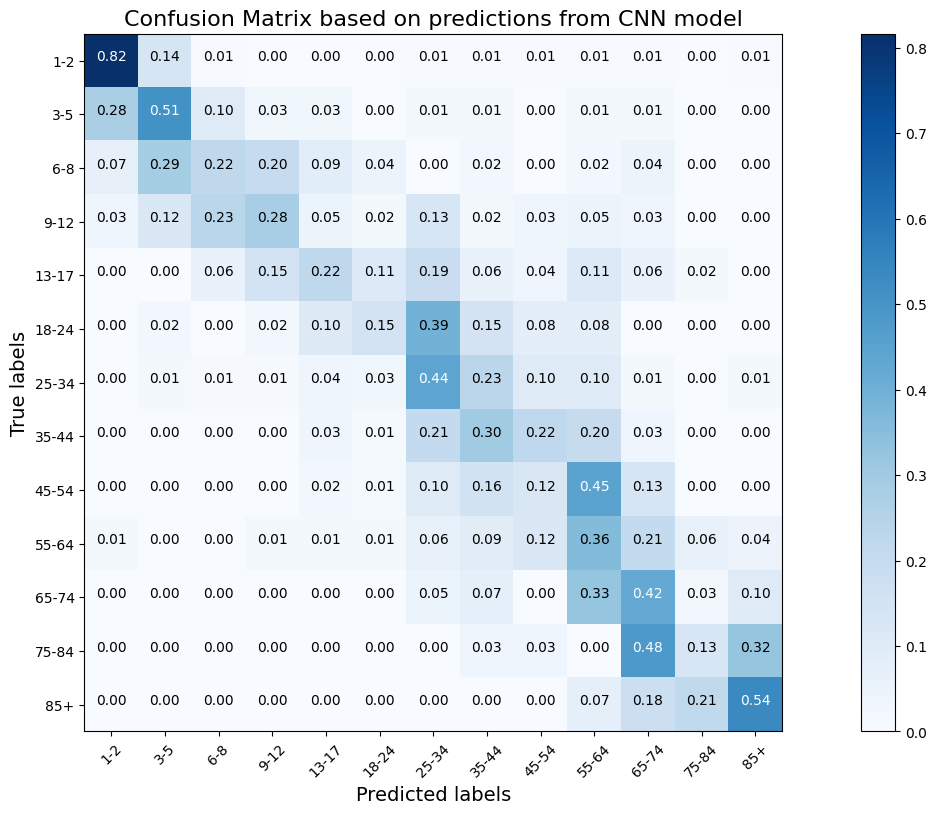

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 743ms/step
Normalized confusion matrix


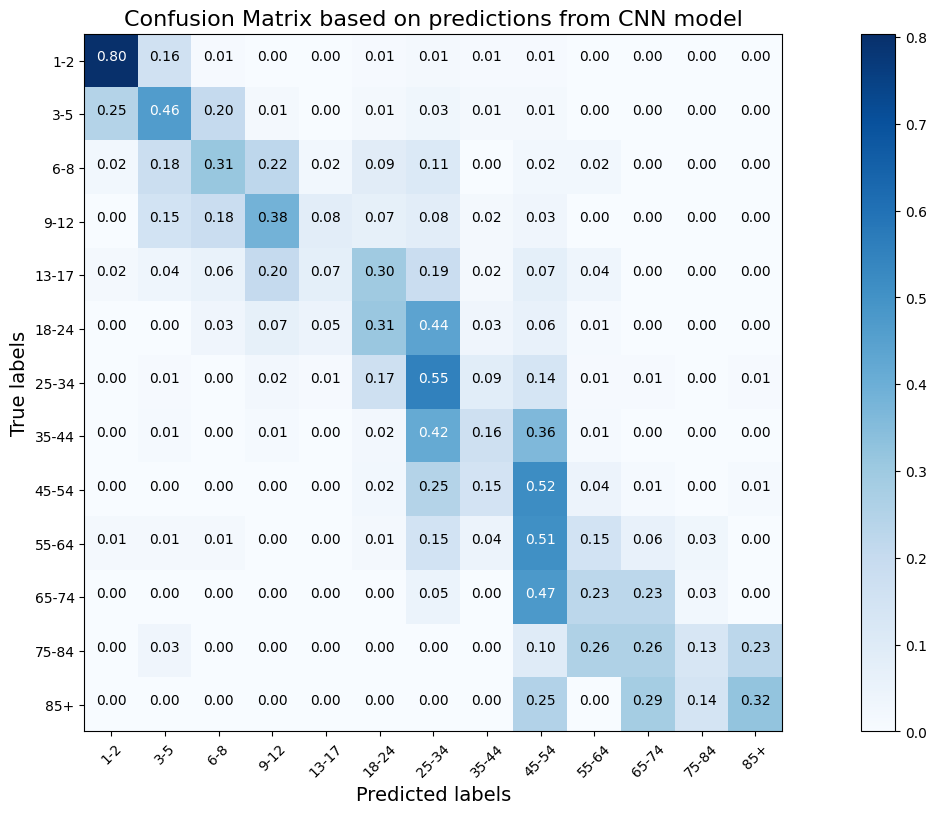

In [ ]:
# Generating predictions from the model above.
cm_plot_labels = ['1-2', '3-5', '6-8', '9-12', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+']

for i, model_entry in enumerate(models):
    df_model = df_combined[df_combined['model'] == model_entry]
    df_top1 = df_model.nlargest(1, 'accuracy').sort_values('epoch')
    model_pred =df_top1['model_object'].iloc[0].predict(test_dataset)
    model_pred = model_pred.argmax(axis=-1)
    conf_mat = confusion_matrix(paths_test_labels_list, model_pred)
    plt.figure(figsize=(16,8))
    plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                          title="Confusion Matrix based on predictions from CNN model",
                          export_as="final_cnn_conf_mat_norm"
                         )
    plt.show()


